# Предобработка данных

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

### Пути к тестовым и тренировочным файлам

In [2]:
DATASET_TRAIN_PATH = './train.csv'
DATASET_TEST_PATH = './test.csv'
PREPARED_DATASET_PATH = './test_prepared.csv'

In [41]:
train_df = pd.read_csv(DATASET_TRAIN_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


### Описание полей датасета
Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

#### Привидение типов полей Id и DistrictId к строке

In [42]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

###  Обработка пропусков

In [43]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [44]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

###  Обработка выбросов

#### Rooms

In [45]:
train_df["Rooms"].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [46]:
train_df.loc[train_df['Rooms'].isin([0,10,19]),'Rooms'] = train_df['Rooms'].median()

#### Square, LifeSquare, KitchenSquare

In [47]:
max_square = train_df['Square'].quantile(.975)
min_square = 15

In [48]:
train_df = train_df[(train_df['Square'] < max_square) & (train_df['Square'] > min_square)]

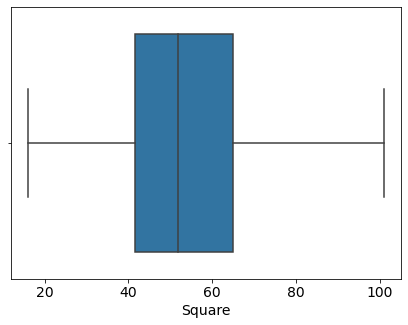

In [49]:
plt.figure(figsize=(7, 5))
sns.boxplot(train_df['Square'], whis=2.5)
plt.xlabel('Square')
plt.show()

In [50]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square']),'LifeSquare'] = train_df['LifeSquare'].median()

In [51]:
train_df.loc[(train_df['KitchenSquare'] > train_df['Square']),'KitchenSquare'] = train_df['KitchenSquare'].median()

#### Floor, HouseFloor

In [52]:
train_df.loc[train_df['HouseFloor'] == 0,'HouseFloor']=train_df['HouseFloor'].median()

In [53]:
floor_out = train_df[train_df['Floor']>train_df['HouseFloor']].index
train_df.loc[floor_out , 'Floor'] = train_df.loc[floor_out , 'HouseFloor'].apply(lambda x: random.randint(1,x))                      

#### HouseYear

In [54]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
3357        2020
4493        2020
8253        2020
          ...   
5053        1917
1380        1917
910         1914
5111        1912
9317        1910
Name: HouseYear, Length: 9737, dtype: int64

In [55]:
train_df.loc[train_df['HouseYear'] > 2022,'HouseYear'] = train_df['HouseYear'].median()

#### Построение новых фичей

In [56]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)
train_df['Ecology_2'] = train_df['Ecology_2'].astype(int)
train_df['Ecology_3'] = train_df['Ecology_3'].astype(int)
train_df['Shops_2'] = train_df['Shops_2'].astype(int)

In [57]:
train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2          int32
Ecology_3          int32
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2            int32
Price            float64
dtype: object

In [58]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId','DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,828
1,1,646
2,23,537
3,6,508
4,9,291


In [59]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,1,33,7976,5,900.0,0,11,1,184966.930730,21
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,46,10309,1,240.0,1,16,1,300009.450063,86
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,1,34,7759,0,229.0,1,3,1,220925.908524,173
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1,23,5735,3,1084.0,0,5,1,175616.227217,176
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,35,5776,1,2078.0,2,4,1,150226.531644,97


In [60]:
(train_df['DistrictSize']>100).value_counts()

True     4945
False    4792
Name: DistrictSize, dtype: int64

In [61]:
train_df['isDistrictLarge']=(train_df['DistrictSize']>100).astype(int)

#### Отбор признаков

In [62]:
train_df.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'isDistrictLarge']

In [63]:
feature_names = ['Rooms',  'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor','HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
                 'Shops_1', 'Shops_2',]

new_feature_names = ['isDistrictLarge']

target_name = 'Price'

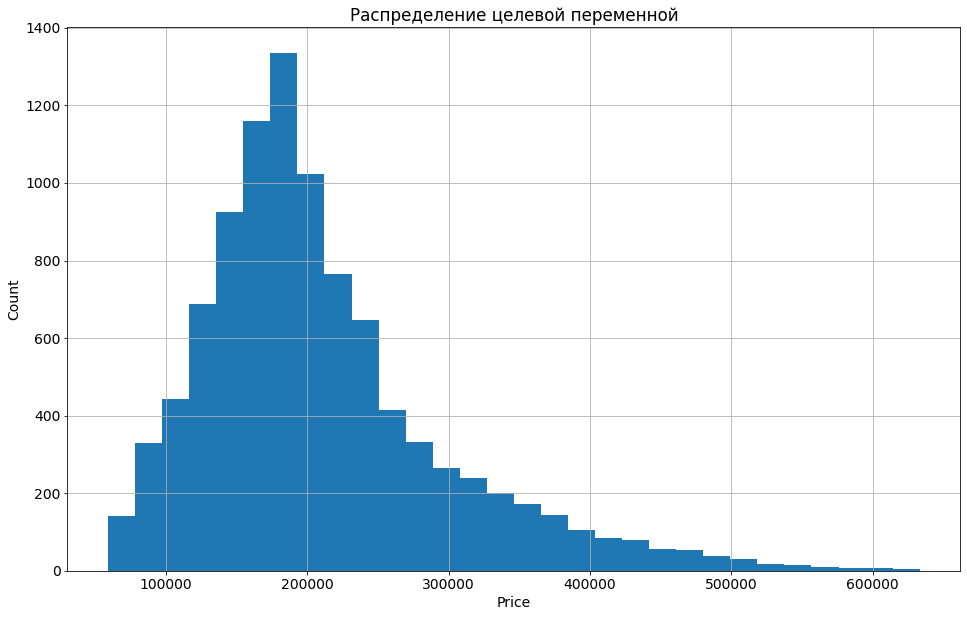

In [64]:
plt.figure(figsize = (16, 10))
train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Распределение целевой переменной')
plt.show()

In [65]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [66]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Разделение на тестовую и тренировочную выборку

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

#### Построение, обучение и оценка модели

Train R2:	0.959
Test R2:	0.743


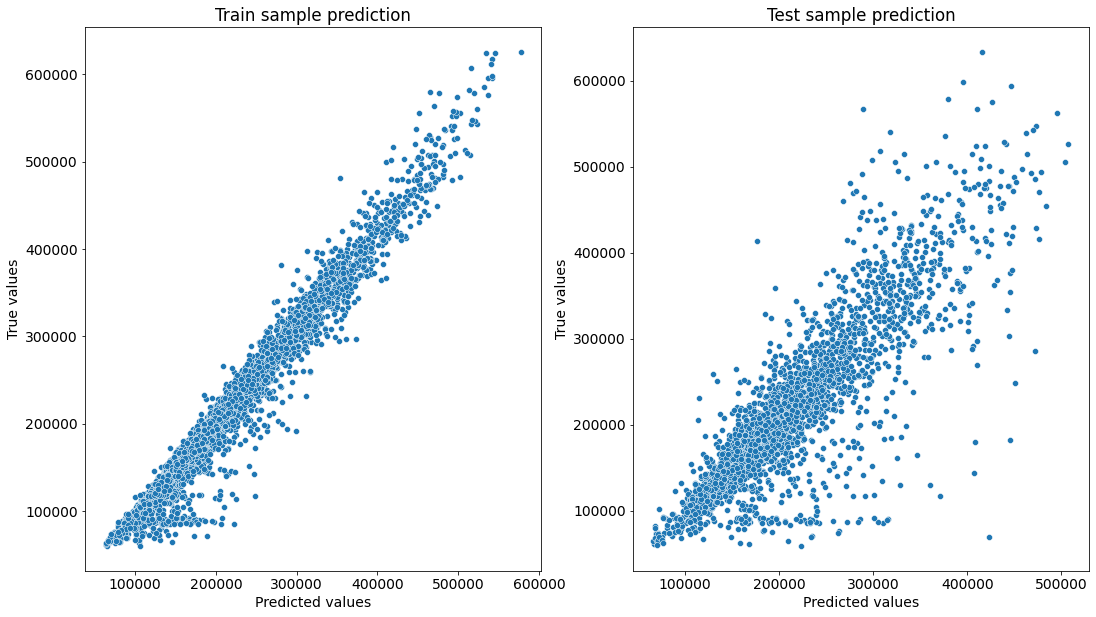

In [68]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [69]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.67929419, 0.70434438, 0.71307371])

In [70]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.380432
10,Social_1,0.125414
17,isDistrictLarge,0.080260
12,Social_3,0.056031
0,Rooms,0.051154
6,HouseYear,0.044227
11,Social_2,0.042673
7,Ecology_1,0.042602
2,LifeSquare,0.034805
13,Healthcare_1,0.032438


In [71]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


#### Предсказание на тестовом наборе

In [156]:
test_df = pd.read_csv(DATASET_TEST_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


#### Подготовка данных тестового датасета

In [157]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Привидение типов

In [158]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

#### Заполнение пропусков

In [159]:
medians = test_df[['LifeSquare', 'Healthcare_1']].median()

In [160]:
test_df[['LifeSquare', 'Healthcare_1']] = test_df[['LifeSquare', 'Healthcare_1']].fillna(medians)

#### Обработка выбросов

In [161]:
test_df["Rooms"].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
0.0        2
17.0       1
Name: Rooms, dtype: int64

In [162]:
test_df.loc[test_df['Rooms'].isin([0,17]),'Rooms'] = test_df['Rooms'].median()

In [163]:
max_square_test = test_df['Square'].quantile(.975)
min_square_test = 15

In [166]:
ind_drop_submit = test_df[(test_df['Square'] >= max_square) | (test_df['Square'] <= min_square)].index
test_df = test_df[(test_df['Square'] < max_square) & (test_df['Square'] > min_square)]

In [167]:
ind_drop_submit

Int64Index([   2,   66,   78,  153,  206,  225,  278,  479,  499,  514,
            ...
            4810, 4845, 4865, 4877, 4880, 4902, 4907, 4937, 4968, 4975],
           dtype='int64', length=134)

In [168]:
test_df.loc[(test_df['LifeSquare'] > test_df['Square']),'LifeSquare'] = test_df['LifeSquare'].median()
test_df.loc[(test_df['KitchenSquare'] > test_df['Square']),'KitchenSquare'] = test_df['KitchenSquare'].median()

In [169]:
test_df.loc[test_df['HouseFloor'] == 0,'HouseFloor']=test_df['HouseFloor'].median()

In [170]:
floor_out = test_df[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[floor_out , 'Floor'] = test_df.loc[floor_out , 'HouseFloor'].apply(lambda x: random.randint(1,x)) 

 #### Генерация фичей

In [171]:
binary_to_numbers = {'A': 0, 'B': 1}

test_df['Ecology_2'] = test_df['Ecology_2'].replace(binary_to_numbers)
test_df['Ecology_3'] = test_df['Ecology_3'].replace(binary_to_numbers)
test_df['Shops_2'] = test_df['Shops_2'].replace(binary_to_numbers)
test_df['Ecology_2'] = test_df['Ecology_2'].astype(int)
test_df['Ecology_3'] = test_df['Ecology_3'].astype(int)
test_df['Shops_2'] = test_df['Shops_2'].astype(int)

In [172]:
district_size = test_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId','DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,375
1,1,341
2,6,253
3,23,247
4,9,130


In [173]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,900.0,0,0,1,89
1,15856,74,2.0,69.263183,32.925087,1.0,1,1.0,1977,0.075779,1,1,6,1437,3,900.0,0,2,1,59
2,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,900.0,3,3,1,48
3,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,900.0,0,0,0,375
4,7633,53,1.0,40.675627,32.925087,1.0,21,21.0,1977,0.049637,1,1,34,7759,0,229.0,1,3,1,89


In [174]:
(test_df['DistrictSize']>100).value_counts()

False    3295
True     1571
Name: DistrictSize, dtype: int64

In [175]:
test_df['isDistrictLarge']=(test_df['DistrictSize']>100).astype(int)

#### Предсказание цен на тестовом наборе

In [176]:
predictions = rf_model.predict(test_df[feature_names + new_feature_names])
predictions

array([158475.81376939, 234441.80754626, 330377.7998939 , ...,
       318338.90091556, 200951.56653416, 178166.97377737])

In [180]:
submit.drop(index=ind_drop_submit,axis=0,inplace=True)

In [182]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,725,158475.813769
1,15856,234441.807546
3,15664,330377.799894
4,14275,143007.391838
5,7633,192518.212804


In [183]:
submit.to_csv('predict_submit.csv', sep=';', index=False)